In [ ]:
%%capture
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar
!pip install tensorflow

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
# import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import *
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 10
np.random.seed(seed_constant)
random.seed(seed_constant)
# tf.random.set_seed(seed_constant)

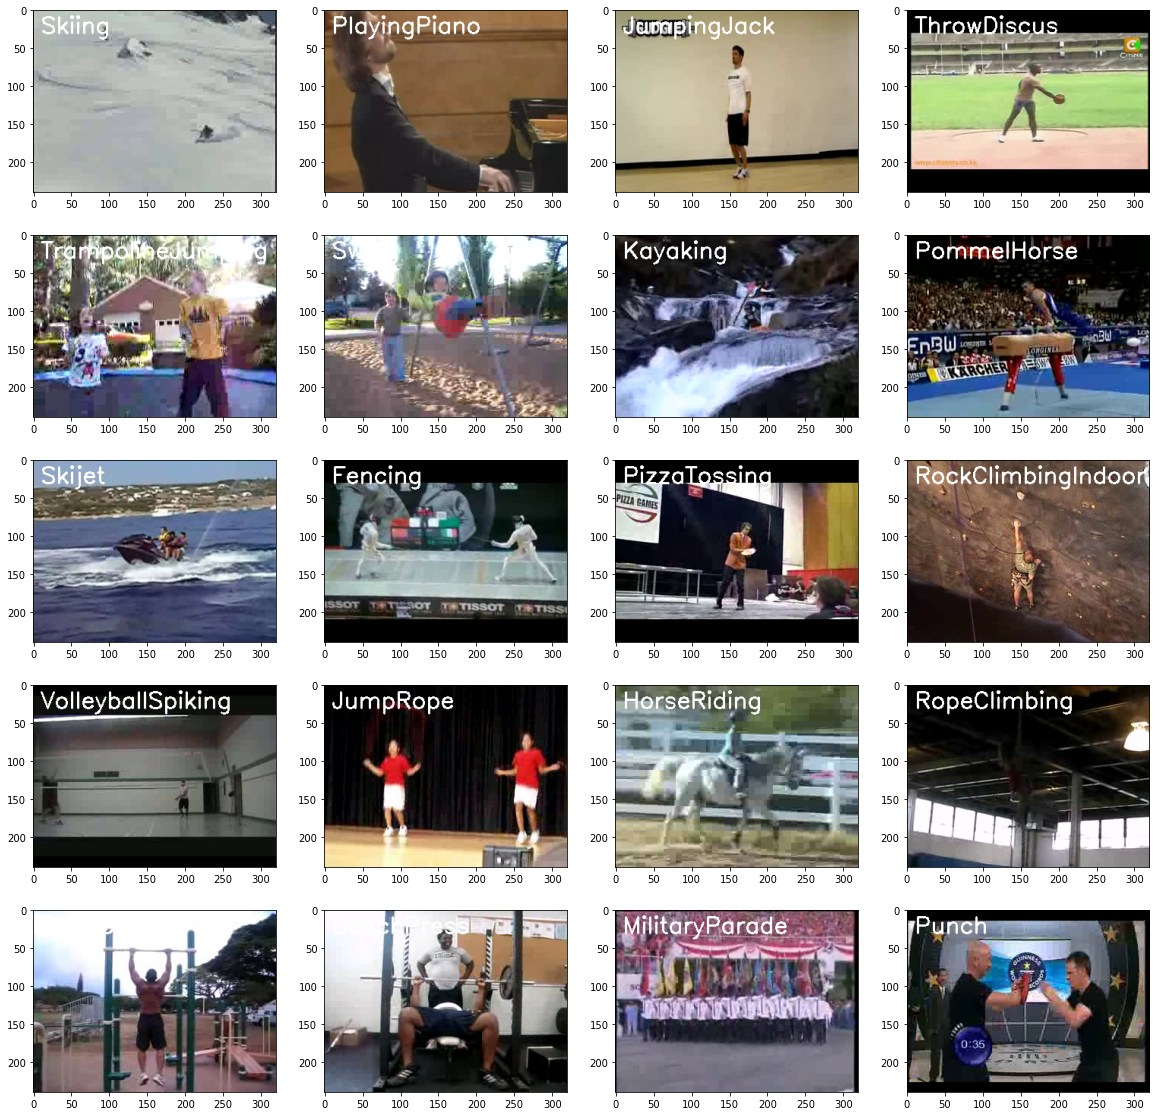

In [ ]:
plt.figure(figsize = (20, 20))
all_classes_names = os.listdir('UCF50')
random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, counter);
    plt.imshow(rgb_frame);
    # plt.axis('off')

In [ ]:
img_h , img_w = 64, 64
seq_len = 20
data_dir = "UCF50"
class_list = ["Skiing", "Skijet", "TaiChi", "Swing", "HorseRace", "HulaHoop"]

In [ ]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/seq_len), 1)
    for frame_counter in range(seq_len):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break

        resized_frame = cv2.resize(frame, (img_h, img_w))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(class_list):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(data_dir, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(data_dir, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == seq_len:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Skiing
Extracting Data of Class: Skijet
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: HulaHoop


In [ ]:
import torch
import torch.nn.functional as F
# x = torch.tensor([1, 0])
one_hot_encoded_labels = F.one_hot(torch.from_numpy(labels), num_classes=6)

# one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)


In [ ]:
def create_convlstm_model():
    model = Sequential()
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (seq_len,
                                                                                      img_h, img_w, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(class_list), activation = "softmax"))
    model.summary()
    return model

In [ ]:
convlstm_model = create_convlstm_model()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 20, 31, 31, 4)    0         
 3D)                                                             
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 31, 31, 4)    0         
 tributed)                                                       
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                      

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])


convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])



Epoch 1/50
110/110 [==============================] - 72s 564ms/step - loss: 1.6877 - accuracy: 0.2938 - val_loss: 1.5061 - val_accuracy: 0.4364
Epoch 2/50
110/110 [==============================] - 60s 547ms/step - loss: 1.3799 - accuracy: 0.4419 - val_loss: 1.4064 - val_accuracy: 0.4636
Epoch 3/50
110/110 [==============================] - 60s 543ms/step - loss: 1.0218 - accuracy: 0.6082 - val_loss: 0.7068 - val_accuracy: 0.7636
Epoch 4/50
110/110 [==============================] - 60s 542ms/step - loss: 0.8407 - accuracy: 0.6788 - val_loss: 0.8351 - val_accuracy: 0.7636
Epoch 5/50
110/110 [==============================] - 60s 548ms/step - loss: 0.5923 - accuracy: 0.7904 - val_loss: 0.7845 - val_accuracy: 0.6727
Epoch 6/50
110/110 [==============================] - 59s 536ms/step - loss: 0.5694 - accuracy: 0.7859 - val_loss: 0.9340 - val_accuracy: 0.6273
Epoch 7/50
110/110 [==============================] - 60s 542ms/step - loss: 0.4533 - accuracy: 0.8405 - val_loss: 0.3424 - val_ac

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

6/6 [==============================] - 1s 99ms/step - loss: 0.5022 - accuracy: 0.8641
